# 01 - Data Exploration & Analysis
## Time Series Anomaly Detection for IoT Sensors

**Author:** Vaishnav M  
**Date:** November 2025

---

## Objective
In this notebook, we will:
1. **Load** the synthetic sensor data
2. **Understand** the data structure and characteristics
3. **Explore** patterns, trends, and seasonality
4. **Visualize** normal behavior vs anomalies
5. **Document** data quality issues

---

## 1. Setup & Imports

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Utilities
import warnings
from datetime import datetime

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.0.3
NumPy version: 1.24.3


## 2. Load the Data

We'll load the synthetic sensor data that we generated earlier.

In [2]:
# Load the data
data_path = '../data/raw/synthetic_sensor_data_with_labels.csv'

df = pd.read_csv(data_path)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as index for time series operations
df_ts = df.set_index('timestamp')

print("✓ Data loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

✓ Data loaded successfully!

Dataset shape: (10000, 6)
Time range: 2024-01-01 00:00:00 to 2024-01-07 22:39:00
Duration: 6 days


## 3. Initial Data Inspection

In [3]:
# Display first few rows
print("First 10 rows:")
display(df.head(10))

First 10 rows:


,timestamp,sensor_1,sensor_2,sensor_3,sensor_4,anomaly
0,2024-01-01 00:00:00,44.467096,43.904921,61.734163,49.144739,0
1,2024-01-01 00:01:00,44.522690,41.985662,65.622300,54.447765,0
2,2024-01-01 00:02:00,48.562752,45.890858,66.956921,51.204399,0
3,2024-01-01 00:03:00,46.834574,41.665150,68.455128,51.723696,0
4,2024-01-01 00:04:00,44.172245,45.702747,62.932034,49.708838,0
5,2024-01-01 00:05:00,46.451553,41.639066,63.465350,53.071008,0
6,2024-01-01 00:06:00,44.296645,42.248037,62.198435,54.557857,0
7,2024-01-01 00:07:00,44.347101,45.755064,65.929953,55.388531,0
8,2024-01-01 00:08:00,45.957655,46.061933,66.662957,51.291315,0
9,2024-01-01 00:09:00,41.277426,45.451362,66.926198,53.610269,0


In [6]:
# Data info
print("\nDataset Information:")
print("=" * 60)
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10000 non-null  datetime64[ns]
 1   sensor_1   10000 non-null  float64       
 2   sensor_2   10000 non-null  float64       
 3   sensor_3   10000 non-null  float64       
 4   sensor_4   10000 non-null  float64       
 5   anomaly    10000 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 468.9 KB


In [4]:
# Statistical summary
print("\nStatistical Summary:")
print("=" * 60)
display(df.describe())


Statistical Summary:


,timestamp,sensor_1,sensor_2,sensor_3,sensor_4,anomaly
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2024-01-04 11:19:30,54.431501,40.576762,69.607509,53.885267,0.042500
min,2024-01-01 00:00:00,28.309286,6.535344,48.401898,37.466642,0.000000
25%,2024-01-02 17:39:45,46.590730,33.213784,62.069718,49.390341,0.000000
50%,2024-01-04 11:19:30,53.978333,40.631429,69.586698,53.922258,0.000000
75%,2024-01-06 04:59:15,61.534019,48.006686,77.095189,58.346433,0.000000
max,2024-01-07 22:39:00,242.701367,61.225745,91.080270,77.131138,1.000000
std,NaN,12.257321,8.551084,8.801544,5.467044,0.201737


## 4. Data Quality Check

In [ ]:
# Check for missing values
print("Missing Values:")
print("=" * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
display(missing_df[missing_df['Missing Count'] > 0])

if missing.sum() == 0:
    print("✓ No missing values detected!")
else:
    print(f"⚠ Total missing values: {missing.sum()}")

In [5]:
# Check for duplicate timestamps
duplicates = df['timestamp'].duplicated().sum()
print(f"\nDuplicate timestamps: {duplicates}")

if duplicates == 0:
    print("✓ No duplicate timestamps!")
else:
    print(f"⚠ Found {duplicates} duplicate timestamps")


Duplicate timestamps: 0
✓ No duplicate timestamps!


In [6]:
# Check timestamp consistency (should be 1 minute intervals)
time_diff = df['timestamp'].diff().dt.total_seconds() / 60
print("\nTime Interval Check:")
print(f"Expected interval: 1 minute")
print(f"Actual intervals (minutes):")
print(time_diff.value_counts().head())

if (time_diff[1:] == 1.0).all():
    print("\n✓ All timestamps are at consistent 1-minute intervals!")
else:
    print("\n⚠ Some irregular time intervals detected")


Time Interval Check:
Expected interval: 1 minute
Actual intervals (minutes):
timestamp
1.0    9999
Name: count, dtype: int64

✓ All timestamps are at consistent 1-minute intervals!


## 5. Anomaly Distribution Analysis

In [7]:
# Anomaly statistics
total_points = len(df)
anomaly_points = df['anomaly'].sum()
normal_points = total_points - anomaly_points
anomaly_ratio = (anomaly_points / total_points) * 100

print("Anomaly Distribution:")
print("=" * 60)
print(f"Total data points: {total_points:,}")
print(f"Normal points: {normal_points:,} ({100 - anomaly_ratio:.2f}%)")
print(f"Anomaly points: {anomaly_points:,} ({anomaly_ratio:.2f}%)")
print("=" * 60)

Anomaly Distribution:
Total data points: 10,000
Normal points: 9,575 (95.75%)
Anomaly points: 425 (4.25%)


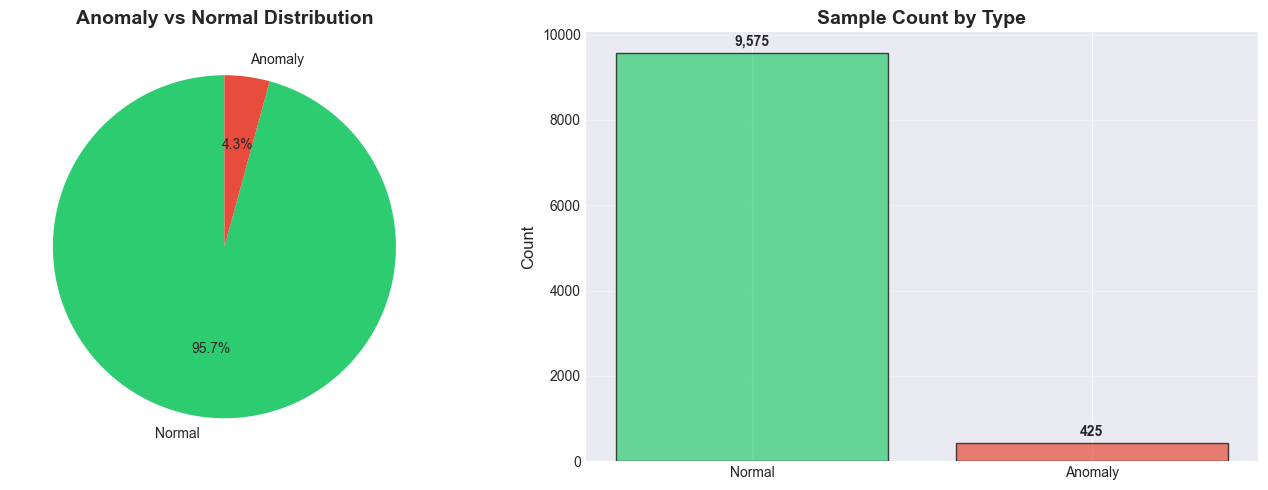

✓ Plot saved to outputs/plots/01_anomaly_distribution.png


In [8]:
# Visualize anomaly distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c']
sizes = [normal_points, anomaly_points]
labels = ['Normal', 'Anomaly']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Anomaly vs Normal Distribution', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(labels, sizes, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Sample Count by Type', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sizes):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/plots/01_anomaly_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/01_anomaly_distribution.png")

## 6. Sensor Data Visualization

Let's visualize each sensor's behavior over time.

In [9]:
# Get sensor columns
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
print(f"Sensors to analyze: {sensor_cols}")

Sensors to analyze: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']


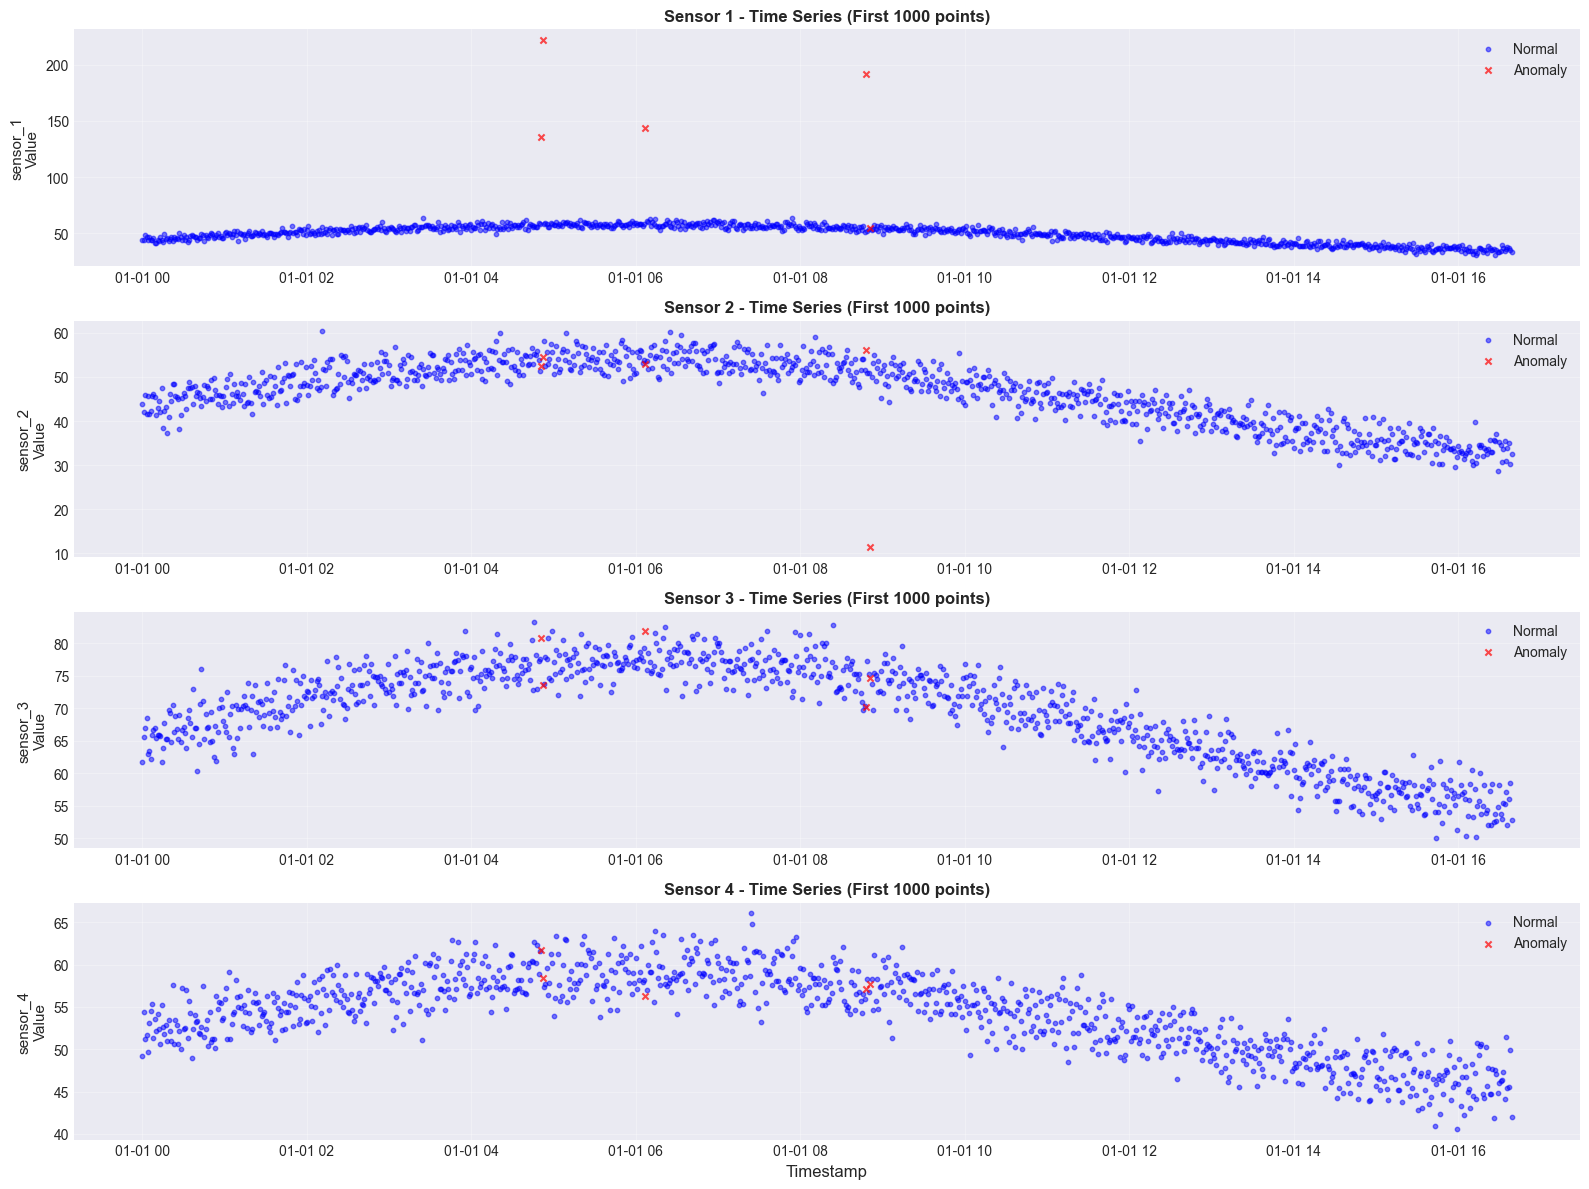

✓ Plot saved to outputs/plots/02_all_sensors_timeseries.png


In [10]:
# Plot all sensors (first 1000 points for clarity)
n_points = 1000
df_subset = df.head(n_points)

fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(16, 12))

for idx, sensor in enumerate(sensor_cols):
    ax = axes[idx]
    
    # Plot normal points
    normal_mask = df_subset['anomaly'] == 0
    ax.scatter(df_subset.loc[normal_mask, 'timestamp'], 
              df_subset.loc[normal_mask, sensor],
              c='blue', s=10, alpha=0.5, label='Normal')
    
    # Plot anomaly points
    anomaly_mask = df_subset['anomaly'] == 1
    ax.scatter(df_subset.loc[anomaly_mask, 'timestamp'],
              df_subset.loc[anomaly_mask, sensor],
              c='red', s=20, alpha=0.7, label='Anomaly', marker='x')
    
    ax.set_ylabel(f'{sensor}\nValue', fontsize=11)
    ax.set_title(f'{sensor.replace("_", " ").title()} - Time Series (First {n_points} points)',
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Timestamp', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/plots/02_all_sensors_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/02_all_sensors_timeseries.png")

## 7. Statistical Analysis per Sensor

In [11]:
# Detailed statistics for each sensor
print("\nDetailed Sensor Statistics:")
print("=" * 80)

for sensor in sensor_cols:
    print(f"\n{sensor.upper()}:")
    print("-" * 80)
    
    sensor_data = df[sensor]
    
    # Normal data statistics
    normal_data = df.loc[df['anomaly'] == 0, sensor]
    anomaly_data = df.loc[df['anomaly'] == 1, sensor]
    
    print(f"Overall Statistics:")
    print(f"  Mean: {sensor_data.mean():.2f}")
    print(f"  Std Dev: {sensor_data.std():.2f}")
    print(f"  Min: {sensor_data.min():.2f}")
    print(f"  Max: {sensor_data.max():.2f}")
    print(f"  Range: {sensor_data.max() - sensor_data.min():.2f}")
    
    print(f"\nNormal Data:")
    print(f"  Mean: {normal_data.mean():.2f}")
    print(f"  Std Dev: {normal_data.std():.2f}")
    
    print(f"\nAnomaly Data:")
    print(f"  Mean: {anomaly_data.mean():.2f}")
    print(f"  Std Dev: {anomaly_data.std():.2f}")


Detailed Sensor Statistics:

SENSOR_1:
--------------------------------------------------------------------------------
Overall Statistics:
  Mean: 54.43
  Std Dev: 12.26
  Min: 28.31
  Max: 242.70
  Range: 214.39

Normal Data:
  Mean: 54.12
  Std Dev: 10.06

Anomaly Data:
  Mean: 61.35
  Std Dev: 34.77

SENSOR_2:
--------------------------------------------------------------------------------
Overall Statistics:
  Mean: 40.58
  Std Dev: 8.55
  Min: 6.54
  Max: 61.23
  Range: 54.69

Normal Data:
  Mean: 40.90
  Std Dev: 8.36

Anomaly Data:
  Mean: 33.32
  Std Dev: 9.60

SENSOR_3:
--------------------------------------------------------------------------------
Overall Statistics:
  Mean: 69.61
  Std Dev: 8.80
  Min: 48.40
  Max: 91.08
  Range: 42.68

Normal Data:
  Mean: 69.77
  Std Dev: 8.88

Anomaly Data:
  Mean: 65.94
  Std Dev: 5.68

SENSOR_4:
--------------------------------------------------------------------------------
Overall Statistics:
  Mean: 53.89
  Std Dev: 5.47
  Min: 37

## 8. Distribution Analysis

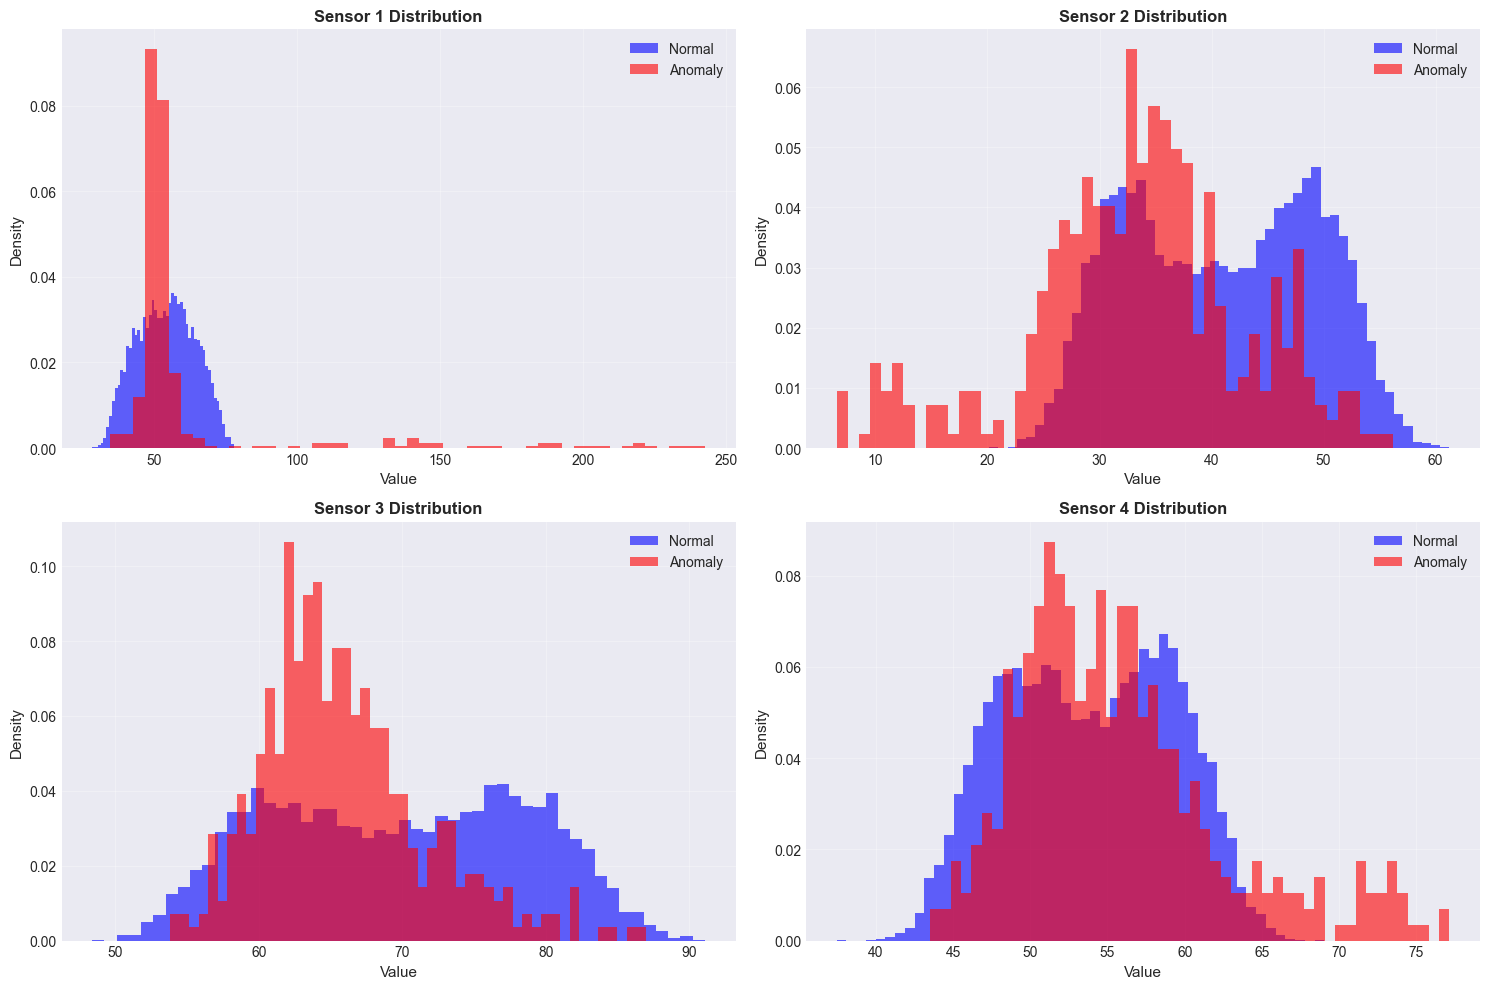

✓ Plot saved to outputs/plots/03_sensor_distributions.png


In [13]:
# Distribution plots for each sensor
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, sensor in enumerate(sensor_cols):
    ax = axes[idx]
    
    # Normal data distribution
    normal_data = df.loc[df['anomaly'] == 0, sensor]
    anomaly_data = df.loc[df['anomaly'] == 1, sensor]
    
    ax.hist(normal_data, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    ax.hist(anomaly_data, bins=50, alpha=0.6, label='Anomaly', color='red', density=True)
    
    ax.set_xlabel('Value', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{sensor.replace("_", " ").title()} Distribution', 
                fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/03_sensor_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/03_sensor_distributions.png")

## 9. Correlation Analysis

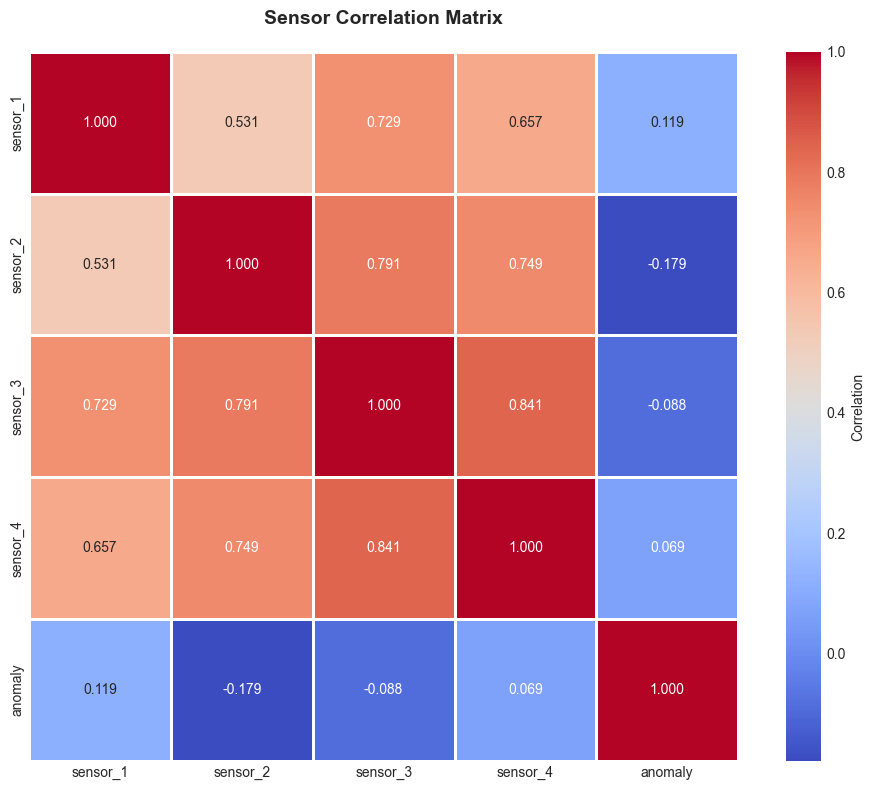

✓ Plot saved to outputs/plots/04_correlation_matrix.png

Correlation with Anomaly Label:
anomaly     1.000000
sensor_1    0.118905
sensor_4    0.069001
sensor_3   -0.087869
sensor_2   -0.178847
Name: anomaly, dtype: float64


In [14]:
# Correlation matrix
correlation_cols = sensor_cols + ['anomaly']
corr_matrix = df[correlation_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Sensor Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/plots/04_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/04_correlation_matrix.png")
print("\nCorrelation with Anomaly Label:")
print(corr_matrix['anomaly'].sort_values(ascending=False))

## 10. Seasonal Decomposition (Sample Sensor)

Let's decompose the time series to see trend and seasonal components.

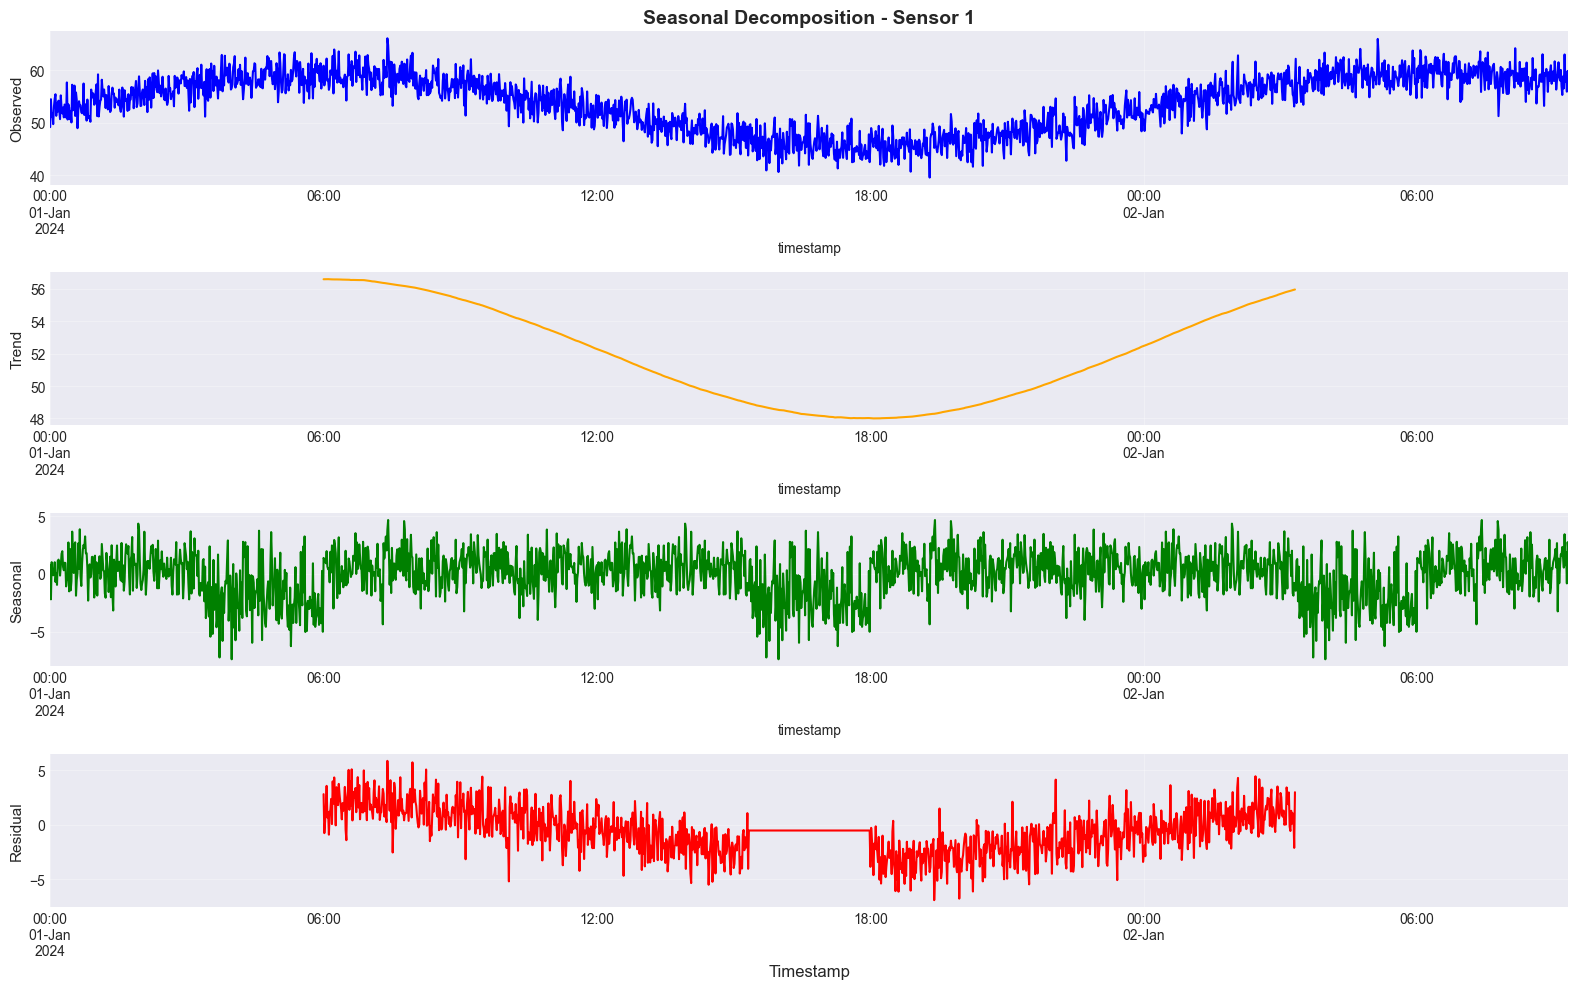

✓ Plot saved to outputs/plots/05_seasonal_decomposition.png


In [21]:
# Take first 2000 points of sensor_1 for decomposition
n_points = 2000
sensor_sample = df_ts['sensor_4'].head(n_points)

# Perform seasonal decomposition
# Period = 1440 minutes (1 day)
decomposition = seasonal_decompose(sensor_sample, model='additive', period=720)
# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 10))

decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed', fontsize=11)
axes[0].set_title('Seasonal Decomposition - Sensor 1', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='orange')
axes[1].set_ylabel('Trend', fontsize=11)
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal', fontsize=11)
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='red')
axes[3].set_ylabel('Residual', fontsize=11)
axes[3].set_xlabel('Timestamp', fontsize=12)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/05_seasonal_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/05_seasonal_decomposition.png")

## 11. Key Findings & Summary

### Data Quality Assessment:
1. ✓ **No missing values** - Data is complete
2. ✓ **No duplicate timestamps** - Unique time points
3. ✓ **Consistent intervals** - Regular 1-minute sampling
4. ✓ **No extreme outliers** (except intentional anomalies)

### Data Characteristics:
1. **Multiple sensors** capture different aspects of equipment behavior
2. **Clear seasonality** - Daily patterns visible in the data
3. **Gradual trends** - Slight upward/downward drifts over time
4. **Noise present** - Random fluctuations simulate real sensor behavior

### Anomaly Observations:
1. Anomalies are **clearly distinguishable** from normal patterns
2. Different types present: **point, contextual, and collective**
3. Anomalies affect **sensor readings significantly**
4. Some sensors show **stronger anomaly signals** than others

### Next Steps:
1. ✓ Data is **ready for feature engineering**
2. No preprocessing needed (already clean)
3. Can proceed to **create derived features**
4. Ready for **model training**

In [17]:
print("="*80)
print("EXPLORATION COMPLETE!")
print("="*80)
print("\n✓ Data has been thoroughly explored")
print("✓ All quality checks passed")
print("✓ Visualizations saved to outputs/plots/")
print("\nReady to proceed to Feature Engineering (Notebook 02)")

EXPLORATION COMPLETE!

✓ Data has been thoroughly explored
✓ All quality checks passed
✓ Visualizations saved to outputs/plots/

Ready to proceed to Feature Engineering (Notebook 02)
